Loading embeddings from: ./embeddings/final_embeddings_molecules_20250308_221455.pkl
Loaded 41 embeddings
Reducing dimensionality with UMAP...
Rebuilding molecules from graph data...
Successfully rebuilt 41 molecules
Selecting representative molecules...
Creating visualization...


C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved visualization to ./visualizations/molecular_embedding_visualization.png
Done!


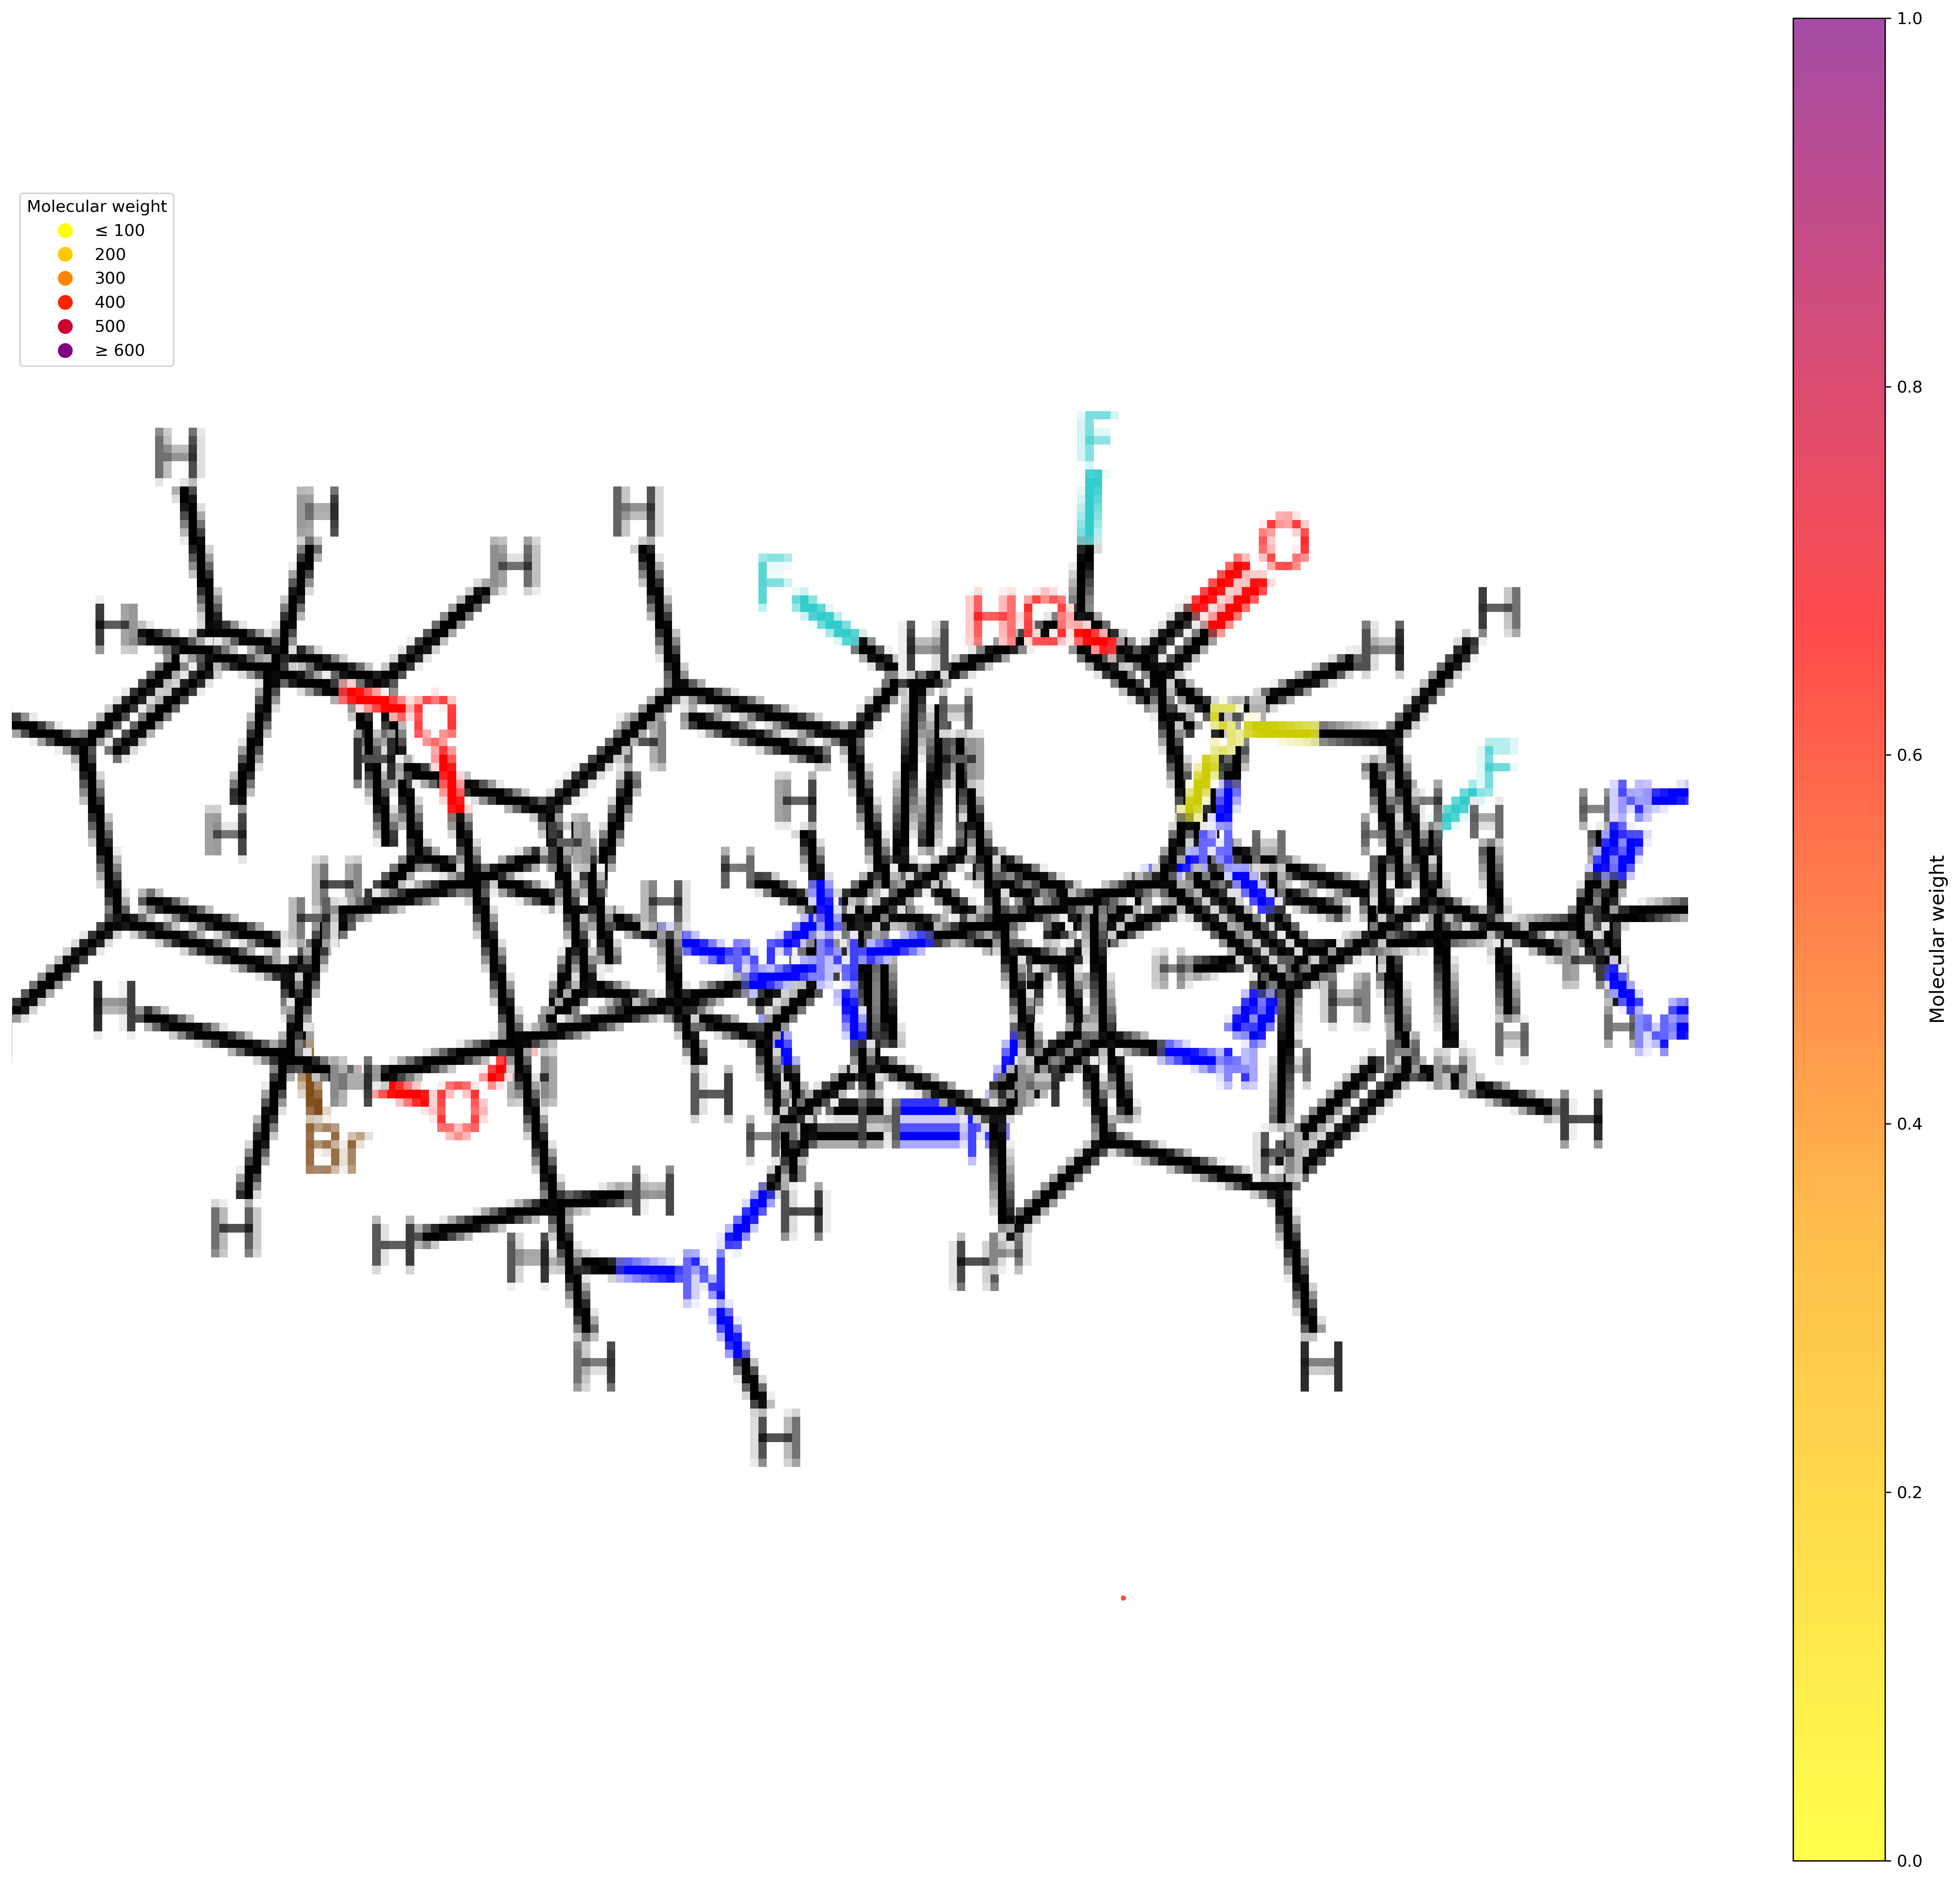

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch
import umap
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from PIL import Image
import io
import os
from matplotlib.lines import Line2D
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

def load_embeddings(filepath):
    """Load embeddings and molecule data from file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = data['embeddings']
    molecule_data = data.get('molecule_data', None)
    
    return embeddings, molecule_data

def rebuild_molecules_from_graph_data(molecule_data_list):
    """Reconstruct RDKit molecules from graph data - simplified version"""
    # Maps for atom and bond features
    atom_list = list(range(1, 119))
    bond_list = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE, 
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]
    
    molecules = []
    valid_count = 0
    
    for mol_data in molecule_data_list:
        try:
            # Create empty editable molecule
            mol = Chem.RWMol()
            
            # Add atoms based on x_cat data
            x_cat = mol_data.get('x_cat')
            if x_cat is None:
                molecules.append(None)
                continue
                
            for atom_features in x_cat:
                atomic_num = atom_list[atom_features[0]]
                atom = Chem.Atom(atomic_num)
                mol.AddAtom(atom)
            
            # Add bonds based on edge_index and edge_attr
            edge_index = mol_data.get('edge_index')
            edge_attr = mol_data.get('edge_attr')
            
            if edge_index is None or edge_attr is None:
                molecules.append(None)
                continue
                
            # Process only in one direction (undirected edges appear twice)
            processed_edges = set()
            
            for i in range(len(edge_index[0])):
                start, end = edge_index[0][i], edge_index[1][i]
                if (start, end) in processed_edges or (end, start) in processed_edges:
                    continue
                    
                # Add the bond
                try:
                    bond_type_idx = int(edge_attr[i][0])
                    if bond_type_idx < len(bond_list):
                        bond_type = bond_list[bond_type_idx]
                        mol.AddBond(start, end, bond_type)
                        processed_edges.add((start, end))
                except Exception:
                    continue
            
            # Convert to molecule
            try:
                final_mol = Chem.Mol(mol)
                for atom in final_mol.GetAtoms():
                    atom.UpdatePropertyCache(strict=False)
                Chem.SanitizeMol(final_mol, Chem.SanitizeFlags.SANITIZE_FINDRADICALS | 
                                  Chem.SanitizeFlags.SANITIZE_KEKULIZE | 
                                  Chem.SanitizeFlags.SANITIZE_SETAROMATICITY | 
                                  Chem.SanitizeFlags.SANITIZE_SETCONJUGATION | 
                                  Chem.SanitizeFlags.SANITIZE_SETHYBRIDIZATION | 
                                  Chem.SanitizeFlags.SANITIZE_SYMMRINGS,
                                  catchErrors=True)
                AllChem.Compute2DCoords(final_mol)
                molecules.append(final_mol)
                valid_count += 1
            except Exception:
                molecules.append(None)
                
        except Exception:
            molecules.append(None)
    
    print(f"Successfully rebuilt {valid_count} molecules")
    return molecules

def mol_to_image(mol, size=(200, 180)):
    """Convert RDKit molecule to PIL Image with transparent background"""
    if mol is None:
        return None
    
    try:
        # Use simpler method to render molecule
        drawer = Draw.MolDraw2DCairo(size[0], size[1])
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        png_data = drawer.GetDrawingText()
        
        # Convert to PIL Image
        img = Image.open(io.BytesIO(png_data))
        
        # Convert to RGBA if not already
        if img.mode != 'RGBA':
            img = img.convert('RGBA')
        
        # Make white or near-white pixels transparent
        datas = img.getdata()
        newData = []
        for item in datas:
            if item[0] > 240 and item[1] > 240 and item[2] > 240:
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
        
        img.putdata(newData)
        return img
    except Exception:
        return None

def create_molecular_weight_colormap():
    """Create a custom colormap similar to the reference image"""
    # Define the colors from light yellow to dark red/purple
    colors = [
        (1.0, 1.0, 0.0),      # light yellow
        (1.0, 0.65, 0.0),     # orange
        (1.0, 0.0, 0.0),      # red
        (0.5, 0.0, 0.5)       # purple
    ]
    
    # Create colormap
    cmap = LinearSegmentedColormap.from_list("molecular_weight", colors)
    return cmap

def select_display_molecules(embeddings_2d, n_samples=12):
    """Select molecules to display around the embedding space"""
    num_points = embeddings_2d.shape[0]
    
    # Calculate the plot bounds
    x_min, x_max = embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max()
    y_min, y_max = embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max()
    
    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min
    
    # Expand the bounds slightly
    x_min -= width * 0.05
    x_max += width * 0.05
    y_min -= height * 0.05
    y_max += height * 0.05
    
    # Define regions for molecule selection - 8 regions around the perimeter
    regions = [
        # Left side (3 regions)
        {'x_min': x_min, 'x_max': x_min + width * 0.25, 'y_min': y_min, 'y_max': y_min + height * 0.33},
        {'x_min': x_min, 'x_max': x_min + width * 0.25, 'y_min': y_min + height * 0.33, 'y_max': y_min + height * 0.66},
        {'x_min': x_min, 'x_max': x_min + width * 0.25, 'y_min': y_min + height * 0.66, 'y_max': y_max},
        
        # Right side (3 regions)
        {'x_min': x_max - width * 0.25, 'x_max': x_max, 'y_min': y_min, 'y_max': y_min + height * 0.33},
        {'x_min': x_max - width * 0.25, 'x_max': x_max, 'y_min': y_min + height * 0.33, 'y_max': y_min + height * 0.66},
        {'x_min': x_max - width * 0.25, 'x_max': x_max, 'y_min': y_min + height * 0.66, 'y_max': y_max},
        
        # Top and bottom (3 regions each)
        {'x_min': x_min + width * 0.25, 'x_max': x_min + width * 0.5, 'y_min': y_max - height * 0.25, 'y_max': y_max},
        {'x_min': x_min + width * 0.5, 'x_max': x_min + width * 0.75, 'y_min': y_max - height * 0.25, 'y_max': y_max},
        {'x_min': x_min + width * 0.75, 'x_max': x_max - width * 0.25, 'y_min': y_max - height * 0.25, 'y_max': y_max},
        
        {'x_min': x_min + width * 0.25, 'x_max': x_min + width * 0.5, 'y_min': y_min, 'y_max': y_min + height * 0.25},
        {'x_min': x_min + width * 0.5, 'x_max': x_min + width * 0.75, 'y_min': y_min, 'y_max': y_min + height * 0.25},
        {'x_min': x_min + width * 0.75, 'x_max': x_max - width * 0.25, 'y_min': y_min, 'y_max': y_min + height * 0.25}
    ]
    
    # Select one point from each region
    selected_indices = []
    
    for region in regions:
        # Find points in this region
        mask = ((embeddings_2d[:, 0] >= region['x_min']) & 
                (embeddings_2d[:, 0] <= region['x_max']) & 
                (embeddings_2d[:, 1] >= region['y_min']) & 
                (embeddings_2d[:, 1] <= region['y_max']))
        
        indices = np.where(mask)[0]
        
        if len(indices) > 0:
            # Select a random point from this region
            selected_idx = np.random.choice(indices)
            selected_indices.append(selected_idx)
    
    # If we didn't get enough samples, add more randomly
    if len(selected_indices) < n_samples:
        remaining = n_samples - len(selected_indices)
        available_indices = np.setdiff1d(np.arange(num_points), selected_indices)
        
        if len(available_indices) >= remaining:
            additional = np.random.choice(available_indices, remaining, replace=False)
            selected_indices.extend(additional)
    
    return selected_indices[:n_samples]

def calculate_image_positions(embeddings_2d, selected_indices, img_size=(200, 180)):
    """Calculate positions for molecule images around the embedding plot"""
    # Calculate plot bounds
    x_min, x_max = embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max()
    y_min, y_max = embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max()
    
    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min
    
    # Expand bounds for image placement
    x_min -= width * 0.4
    x_max += width * 0.4
    y_min -= height * 0.4
    y_max += height * 0.4
    
    # Calculate positions for each selected molecule
    positions = []
    
    for idx in selected_indices:
        x, y = embeddings_2d[idx]
        
        # Determine region (left, right, top, bottom, or corners)
        rel_x = (x - x_min) / (x_max - x_min)  # 0 to 1 position
        rel_y = (y - y_min) / (y_max - y_min)  # 0 to 1 position
        
        # Determine image and arrow positions based on point location
        img_pos = None
        arrow_start = None
        
        if rel_x < 0.3:  # Left side
            img_x = x_min
            img_y = y - img_size[1]/200
            arrow_start = (img_x + img_size[0]/100, y)
        elif rel_x > 0.7:  # Right side
            img_x = x_max - img_size[0]/100
            img_y = y - img_size[1]/200
            arrow_start = (img_x, y)
        elif rel_y < 0.3:  # Bottom
            img_x = x - img_size[0]/200
            img_y = y_min
            arrow_start = (x, img_y + img_size[1]/100)
        elif rel_y > 0.7:  # Top
            img_x = x - img_size[0]/200
            img_y = y_max - img_size[1]/100
            arrow_start = (x, img_y)
        else:
            # Inside the plot - place based on distance to edges
            dist_left = x - x_min
            dist_right = x_max - x
            dist_top = y_max - y
            dist_bottom = y - y_min
            
            min_dist = min(dist_left, dist_right, dist_top, dist_bottom)
            
            if min_dist == dist_left:
                img_x = x_min
                img_y = y - img_size[1]/200
                arrow_start = (img_x + img_size[0]/100, y)
            elif min_dist == dist_right:
                img_x = x_max - img_size[0]/100
                img_y = y - img_size[1]/200
                arrow_start = (img_x, y)
            elif min_dist == dist_top:
                img_x = x - img_size[0]/200
                img_y = y_max - img_size[1]/100
                arrow_start = (x, img_y)
            else:
                img_x = x - img_size[0]/200
                img_y = y_min
                arrow_start = (x, img_y + img_size[1]/100)
        
        positions.append({
            'img_pos': (img_x, img_y),
            'arrow_start': arrow_start,
            'arrow_end': (x, y)
        })
    
    return positions

def visualize_embedding(embeddings_2d, molecules, selected_indices=None, 
                     figsize=(16, 14), dpi=300, save_path=None):
    """Create visualization with molecule structures around the plot"""
    # Select molecules to display if not provided
    if selected_indices is None:
        selected_indices = select_display_molecules(embeddings_2d, n_samples=12)
    
    # Filter out invalid indices
    selected_indices = [idx for idx in selected_indices if idx < len(molecules)]
    selected_indices = [idx for idx in selected_indices if molecules[idx] is not None]
    
    # Create figure with white background
    fig = plt.figure(figsize=figsize, dpi=dpi, facecolor='white')
    ax = plt.gca()
    
    # Create custom colormap
    cmap = create_molecular_weight_colormap()
    
    # Assign colors based on position instead of molecular weight
    # Calculate distance from center for each point
    center = np.mean(embeddings_2d, axis=0)
    distances = np.sqrt(np.sum((embeddings_2d - center)**2, axis=1))
    
    # Normalize distances to 0-1 range for colormap
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    norm_distances = (distances - min_dist) / (max_dist - min_dist)
    
    # Plot points with colors based on distance
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=norm_distances,
        cmap=cmap, 
        alpha=0.7, 
        s=5
    )
    
    # Calculate positions for molecule images
    positions = calculate_image_positions(embeddings_2d, selected_indices)
    
    # Add molecule images and connecting arrows
    for i, idx in enumerate(selected_indices):
        # Skip if invalid
        if idx >= len(molecules) or molecules[idx] is None:
            continue
            
        # Convert molecule to image
        img = mol_to_image(molecules[idx])
        if img is None:
            continue
        
        # Get position information
        pos = positions[i]
        img_pos = pos['img_pos']
        arrow_start = pos['arrow_start']
        arrow_end = pos['arrow_end']
        
        # Add molecule image
        ax.imshow(img, extent=[
            img_pos[0], img_pos[0] + img.width/100,
            img_pos[1], img_pos[1] + img.height/100
        ], zorder=10)
        
        # Draw dashed arrow connecting to the point
        arrow = FancyArrowPatch(
            arrow_start, arrow_end,
            connectionstyle="arc3,rad=0.1",
            arrowstyle="-",
            linestyle='--',
            color='gray',
            linewidth=1,
            alpha=0.7,
            zorder=5
        )
        ax.add_patch(arrow)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Molecular weight', fontsize=12)
    
    # Create legend for molecular weight
    weights = [100, 200, 300, 400, 500, 600]
    weight_colors = [cmap(i/5) for i in range(6)]
    
    # Add weight legend to the left side
    handles = []
    for i, (w, c) in enumerate(zip(weights, weight_colors)):
        if i == 0:
            handles.append(Line2D([0], [0], color=c, marker='o', linestyle='None', 
                                 markersize=8, label=f'≤ {w}'))
        elif i == len(weights) - 1:
            handles.append(Line2D([0], [0], color=c, marker='o', linestyle='None',
                                 markersize=8, label=f'≥ {w}'))
        else:
            handles.append(Line2D([0], [0], color=c, marker='o', linestyle='None',
                                 markersize=8, label=f'{w}'))
    
    # Add legend
    ax.legend(
        handles=handles, 
        loc='upper left', 
        title='Molecular weight',
        frameon=True
    )
    
    # Remove ticks for clean visualization
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove border
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Saved visualization to {save_path}")
    
    return fig

def main():
    # Create output directory
    os.makedirs('./visualizations', exist_ok=True)
    
    # Load embeddings
    embeddings_path = './embeddings/final_embeddings_molecules_20250308_221455.pkl'  # Update with your actual path
    print(f"Loading embeddings from: {embeddings_path}")
    
    try:
        embeddings, molecule_data = load_embeddings(embeddings_path)
        print(f"Loaded {len(embeddings)} embeddings")
    except Exception as e:
        print(f"Error loading embeddings: {e}")
        # Generate dummy data for testing
        print("Generating dummy data for testing...")
        embeddings = np.random.randn(1000, 128)
        molecule_data = [{'x_cat': [[6, 0]] * 10, 
                        'edge_index': [[0, 1], [1, 0]], 
                        'edge_attr': [[0], [0]]} for _ in range(1000)]
    
    # Reduce dimensions
    print("Reducing dimensionality with UMAP...")
    try:
        reducer = umap.UMAP(
            n_neighbors=30,
            min_dist=0.1,
            n_components=2,
            metric='cosine',
            random_state=42
        )
        embeddings_2d = reducer.fit_transform(embeddings)
    except Exception as e:
        print(f"Error reducing dimensions: {e}")
        # Use PCA as fallback
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2)
        embeddings_2d = reducer.fit_transform(embeddings)
    
    # Rebuild molecules
    print("Rebuilding molecules from graph data...")
    molecules = rebuild_molecules_from_graph_data(molecule_data)
    
    # Select representative molecules
    print("Selecting representative molecules...")
    selected_indices = select_display_molecules(embeddings_2d, n_samples=12)
    
    # Create visualization
    print("Creating visualization...")
    fig = visualize_embedding(
        embeddings_2d,
        molecules,
        selected_indices,
        figsize=(18, 16),
        dpi=300,
        save_path='./visualizations/molecular_embedding_visualization.png'
    )
    
    print("Done!")

if __name__ == "__main__":
    main()